<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP

## 1. Recap from Notebook 2

The goal of this project is to use Reddit posts from Dota 2 and League of Legends to build a text classifier that has at least 85% accuracy, and to identify the top 5 features of each game. By categorizing the current content for both games, we will make it easy for our users to navigate and enhance their user experience. The top 5 features will give the marketing team some insight into their sales and marketing strategy.

In Notebook 2, we cleaned and preprocessed the texts. A comparison of the popular words with lemmatizer and stemmer shows no significant differences. We will adopt using lemmatized text for the modeling as the text is more meaningful as compared to stemmed text.

In this Notebook, we will cover:
- Modeling using Multinomial Naive Bayes, Logistic Regression, and K-Nearest Neighbors with different vectorizers (CountVectorizer and TfidfVectorizer) and hyperparameters
- Analyze the misclassified posts
- Identify the feature importance

## 2. Importing Python Modules

In [1]:
import pandas as pd
import numpy as np

# For plotting
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_theme(style='whitegrid') # set theme to be whitegrid

# For modeling
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# For metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#import warnings
#warnings.simplefilter(action='ignore')

## 3. Load the Datasets

In [2]:
# Read the csv file
df = pd.read_csv('../datasets/dota_league.csv')

## 4. Model Evaluation

- For modeling, we will try to predict whether a comment belongs to the DotA2 subreddit or League of Legends subreddit. The dataset will be split into a train and test dataset. 

- Multinomial Naive Bayes, Logistic Regression, K Nearest Neighbors will be applied with two different word vectorizers, Count Vectorizer and Tfidf Vectorizer.

- Pipeline will be applied to define the vectorizer and model and hyperparameters tuning will be done via the GridSearch.

- We will use lemmatized text for the modeling since the differences observed from the popular words visualization is minor and lemmatized text is more meaningful than stemmed text.

### 4.1 Split the Dataset

In [3]:
# Create X and y variables
X = df['text_lem_sen']
y = df['subreddit_int']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)

In [4]:
print(X_train.shape)
print(X_test.shape)

(2560,)
(1098,)


In [5]:
print(y_train.shape)
print(y_test.shape)

(2560,)
(1098,)


### 4.2 Functions for modeling evaluation

In [6]:
# Create a function to plot the confusion matrix
def plot_confusion_matrix(y_test, y_predict):
    cm = confusion_matrix(y_test, y_predict)
    labels = ['DotA2', 'League of Legends']
    cmap=sns.light_palette("blue")
    sns.heatmap(cm, annot=True, cmap=cmap,fmt="d", xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion matrix', fontsize = 16, fontweight = 'bold')

In [7]:
# Create a function to plot the ROC graph
def plot_roc(y_test, y_predict):
    fpr, tpr, thresholds = roc_curve(y_test, y_predict)
    auc = roc_auc_score(y_test, y_predict)
    plt.plot(fpr, tpr, label="AUC= "+str(round(auc,3)))
    plt.plot([0, 1], [0, 1], linestyle='--', label='baseline')
    plt.title('ROC curve', fontsize = 16, fontweight = 'bold')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)

In [8]:
# Create a function to print the test score result
def print_data(y_test, y_predict):
    print('Accuracy score:',round(accuracy_score(y_test, y_predict),6))
    print('ROC AUC score:',round(roc_auc_score(y_test, y_predict),6))
    print('Precision score:',round(precision_score(y_test, y_predict),6))
    print('Recall score:',round(recall_score(y_test, y_predict),6))
    print('F1 score:',round(f1_score(y_test, y_predict),6))

In [9]:
# Create a function to do modeling and plot the confusion matrix and ROC graph
def model_eval(model):
    # Fit GridSearch to training data
    model.fit(X_train, y_train)
    
    dict_scores = {'model': str(model.estimator.steps),
                   'optimal Parameters': model.best_params_,
                   'cross_val_score': model.best_score_,
                   'train_score': model.score(X_train, y_train),
                   'test_score': model.score(X_test, y_test),
                   'auc_score': roc_auc_score(y_test, model.predict(X_test)),
                   'recall': recall_score(y_test, model.predict(X_test)),
                   'precision': precision_score(y_test, model.predict(X_test)),
                   'f1_score': f1_score(y_test, model.predict(X_test))}

    # Convert dict_scores to dataframe and display it
    scores_df = pd.DataFrame.from_dict(dict_scores.items())
    with pd.option_context('display.max_colwidth', 400):
        display(scores_df)
    
    # Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()

    # Plot confusion matrix
    plot_confusion_matrix(y_test, model.predict(X_test))
    plt.show()
    
    # Plot ROC graph
    plot_roc(y_test, model.predict(X_test))
    plt.show()

### 4.3 Baseline Score

In [10]:
y.value_counts(normalize=True)

0    0.501367
1    0.498633
Name: subreddit_int, dtype: float64

The number of posts for DotA2 and League of Legends is 50.1% and 49.9% respectively and is close to 50.0%. Hence, the baseline model is ~50% accurate for classifying a post correctly.

### 4.4 Multinomial Naive Bayes

Multinomial Naive Bayes classifier is predominantly used in text classification based on the Bayes Theorem where it assumes all features are independent of one another. Although the assumption may not be realistic as text data may not be independent of one another, it is still widely used for text classification as it is relatively fast and gives accurate predictions in text classification problems.

In [11]:
# Set up a pipeline up with two stages:
# 1. Vectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe_vec_nb = Pipeline([
    ('vec', None),
    ('nb', MultinomialNB())
])

In [12]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens), check (individual tokens and 2-grams)
# No stop words and english stop words

pipe_params_vec = {
    'vec': [CountVectorizer(), TfidfVectorizer()],
    'vec__stop_words': [None, 'english'],
    'vec__ngram_range': [(1, 1), (1, 2)],
    'vec__max_df': [.9, .95],
    'vec__min_df': [2, 3],
    'vec__max_features': [2_000, 3_000, 4_000, 5_000]
}

In [13]:
# Instantiate GridSearchCV with 5-folds cross valiation
gs_vec_nb = GridSearchCV(pipe_vec_nb,
                          param_grid=pipe_params_vec,
                          cv=5,
                          n_jobs=-1)

,0,1
0,model,"[('vec', None), ('nb', MultinomialNB())]"
1,optimal Parameters,"{'vec': TfidfVectorizer(max_df=0.9, max_features=5000, min_df=2, ngram_range=(1, 2), stop_words='english'), 'vec__max_df': 0.9, 'vec__max_features': 5000, 'vec__min_df': 2, 'vec__ngram_range': (1, 2), 'vec__stop_words': 'english'}"
2,cross_val_score,0.898828
3,train_score,0.966406
4,test_score,0.891621
5,auc_score,0.891709
6,recall,0.915905
7,precision,0.872822
8,f1_score,0.893845


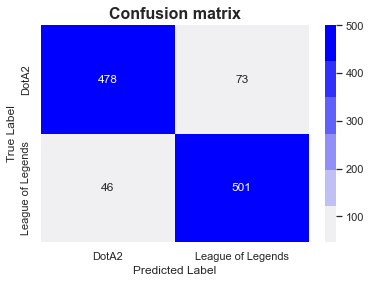

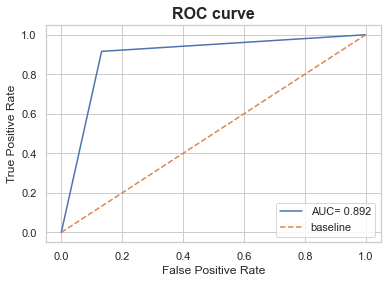

In [14]:
model_eval(gs_vec_nb)

- The model performs much better than our baseline score where it has higher accuracy in predicting the posts correctly.
- The AUC score is 0.8917 and is close to 1. This means the model can distinguish between all the positive and the negative points correctly.
- The recall and precision scores obtained are also high (~0.9). This shows the model returns more relevant results than irrelevant ones.
- There is a slight overfit in model (train score: 0.9664, test score: 0.8916, ~ 7.7% difference) which is still acceptable. 
- We will try to see if tuning the alpha parameters can further improve the score.

In [15]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens), check (individual tokens and 2-grams)
# No stop words and english stop words
# Alpha: 0.1, 0.5, 1.0, 10.0

pipe_params_vec_nb = {
    'vec': [CountVectorizer(), TfidfVectorizer()],
    'vec__stop_words': [None, 'english'],
    'vec__ngram_range': [(1, 1), (1, 2)],
    'vec__max_df': [.9, .95],
    'vec__min_df': [2, 3],
    'vec__max_features': [2_000, 3_000, 4_000, 5_000],
    'nb__alpha': [0.1, 0.5, 1.0, 10.0]
}

In [16]:
# Instantiate GridSearchCV with 5-folds cross valiation
gs_vec_nb1 = GridSearchCV(pipe_vec_nb,
                          param_grid=pipe_params_vec_nb,
                          cv=5,
                          n_jobs=-1)

,0,1
0,model,"[('vec', None), ('nb', MultinomialNB())]"
1,optimal Parameters,"{'nb__alpha': 0.5, 'vec': TfidfVectorizer(max_df=0.9, max_features=4000, min_df=3, stop_words='english'), 'vec__max_df': 0.9, 'vec__max_features': 4000, 'vec__min_df': 3, 'vec__ngram_range': (1, 1), 'vec__stop_words': 'english'}"
2,cross_val_score,0.901172
3,train_score,0.973437
4,test_score,0.893443
5,auc_score,0.893504
6,recall,0.91042
7,precision,0.879859
8,f1_score,0.894879


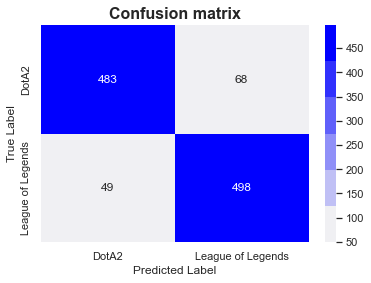

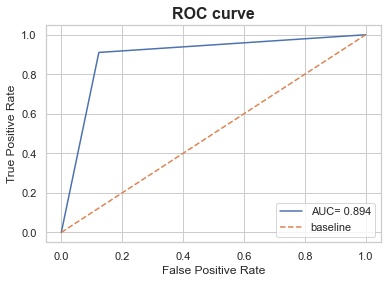

In [17]:
model_eval(gs_vec_nb1)

- Slight improvement in the scores was observed after hyperparameter tuning. This is a better model as compared to the earlier model.
- For both models, TfidfVectorizer is a better vectorizer. This is because it not only focuses on the frequency of words present but also on the importance of the words which helps in reducing the model complexity.


|MultiNomial NB|Optimal Parameter|Train score|Test score|AUC score|Recall score|Precision score|F1 Score
|--|--|--|--|--|--|--|--|
|1|{'vec': TfidfVectorizer(max_df=0.9, max_features=5000, min_df=2, ngram_range=(1, 2), stop_words='english')}|0.9664|0.8916|0.8917|0.9159|0.8728|0.8938
|2|{'nb__alpha': 0.5, 'vec': TfidfVectorizer(max_df=0.9, max_features=4000, min_df=3, stop_words='english')}|0.9734|0.8934|0.8935|0.9104|0.8799|0.8949


### 4.5 Logistic Regression

Logistic Regression is another common binary classification algorithm where it uses the weighted combination of the input features and passes them through a sigmoid function. Sigmoid function transforms any real number input, to a number between 0 and 1. For Logistics Regression, it is also a simple algorithm but it does not assume the features are independent and it is not as fast as Naive Bayes as it iterates over the data until it converges.

In [18]:
# Set up a pipeline up with two stages:
# 1. Vectorizer (transformer)
# 2. Logistic Regression (estimator)

pipe_vec_lr = Pipeline([
    ('vec', None),
    ('lr', LogisticRegression(solver='liblinear'))
])

In [19]:
# Instantiate GridSearchCV with 5-folds cross valiation
gs_vec_lr = GridSearchCV(pipe_vec_lr,
                         param_grid=pipe_params_vec,
                         cv=5,
                         n_jobs=-1)

,0,1
0,model,"[('vec', None), ('lr', LogisticRegression(solver='liblinear'))]"
1,optimal Parameters,"{'vec': TfidfVectorizer(max_df=0.9, max_features=4000, min_df=2, ngram_range=(1, 2)), 'vec__max_df': 0.9, 'vec__max_features': 4000, 'vec__min_df': 2, 'vec__ngram_range': (1, 2), 'vec__stop_words': None}"
2,cross_val_score,0.894531
3,train_score,0.974609
4,test_score,0.883424
5,auc_score,0.883337
6,recall,0.859232
7,precision,0.902111
8,f1_score,0.88015


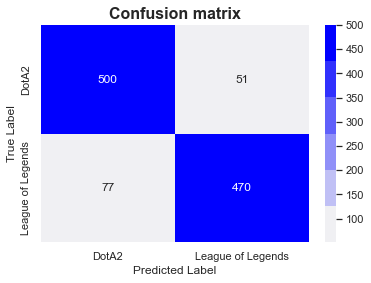

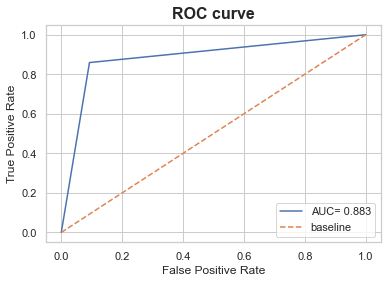

In [20]:
model_eval(gs_vec_lr)

- Logistic Regression also has slight overfitting in model (train score: 0.9746, test score: 0.8834, ~ 9.5% difference). The overfitting is slightly more significant as compared to the Multinomial Naive Bayes model.

- Other than the overfitting, the modal performance is not as good as Multinomial Naive Bayes as the AUC and F1 scores are slightly lower.

- We will try to see if tuning the regularization parameters to see if we can reduce the overfitting and improve the score.


In [21]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens), check (individual tokens and 2-grams)
# No stop words and english stop words
# Regularization (penalty)

pipe_params_vec_lr = {
    'vec': [CountVectorizer(), TfidfVectorizer()],
    'vec__stop_words': [None, 'english'],
    'vec__ngram_range': [(1, 1), (1, 2)],
    'vec__max_df': [.9, .95],
    'vec__min_df': [2, 3],
    'vec__max_features': [2_000, 3_000, 4_000, 5_000],
    'lr__penalty': ['l1','l2']
}

In [22]:
# Instantiate GridSearchCV with 5-folds cross valiation
gs_vec_lr1 = GridSearchCV(pipe_vec_lr,
                          param_grid=pipe_params_vec_lr,
                          cv=5, 
                          n_jobs=-1) 

,0,1
0,model,"[('vec', None), ('lr', LogisticRegression(solver='liblinear'))]"
1,optimal Parameters,"{'lr__penalty': 'l2', 'vec': TfidfVectorizer(max_df=0.9, max_features=4000, min_df=2, ngram_range=(1, 2)), 'vec__max_df': 0.9, 'vec__max_features': 4000, 'vec__min_df': 2, 'vec__ngram_range': (1, 2), 'vec__stop_words': None}"
2,cross_val_score,0.894531
3,train_score,0.974609
4,test_score,0.883424
5,auc_score,0.883337
6,recall,0.859232
7,precision,0.902111
8,f1_score,0.88015


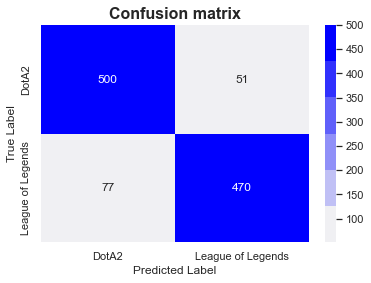

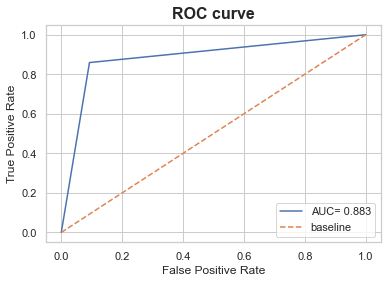

In [23]:
model_eval(gs_vec_lr1)

- No significant reduction in overfitting. The scores are comparable.

- Similar to Multinomial Naive Bayes, TfidfVectorizer is observed to be a better vectorizer.

- Since the overfitting is slightly more significant for Logistic Regression, Multinomial Naive Bayes performs slightly better than Logistics Regression.



|Logistics Regression|Optimal Parameter|Train score|Test score|AUC score|Recall score|Precision score|F1 Score
|--|--|--|--|--|--|--|--|
|1|{'vec': TfidfVectorizer(max_df=0.9, max_features=4000, min_df=2, ngram_range=(1, 2))}|0.9746|0.8834|0.8833|0.8592|0.9021|0.8801
|2|{'lr__penalty': 'l2', 'vec': TfidfVectorizer(max_df=0.9, max_features=4000, min_df=2, ngram_range=(1, 2))}|0.9746|0.8834|0.8833|0.8592|0.9021|0.8801


### 4.6 k-Nearest Neighbours

The k-Nearest neighbor (kNN) algorithm is a supervised machine learning algorithm used for classification and regression. For the context of text classification, the object is classified based on the vote among the k nearest neighbors.

In [24]:
# Set up a pipeline up with two stages:
# 1. Vectorizer (transformer)
# 2. KNN (estimator)

pipe_vec_knn = Pipeline([
    ('vec', None),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

In [25]:
# Instantiate GridSearchCV with 5-folds cross valiation
gs_vec_knn = GridSearchCV(pipe_vec_knn,
                          param_grid=pipe_params_vec,
                          cv=5,
                          n_jobs=-1) 

,0,1
0,model,"[('vec', None), ('knn', KNeighborsClassifier())]"
1,optimal Parameters,"{'vec': CountVectorizer(max_df=0.9, max_features=2000, min_df=3, stop_words='english'), 'vec__max_df': 0.9, 'vec__max_features': 2000, 'vec__min_df': 3, 'vec__ngram_range': (1, 1), 'vec__stop_words': 'english'}"
2,cross_val_score,0.628906
3,train_score,0.698828
4,test_score,0.637523
5,auc_score,0.636357
6,recall,0.316271
7,precision,0.878173
8,f1_score,0.465054


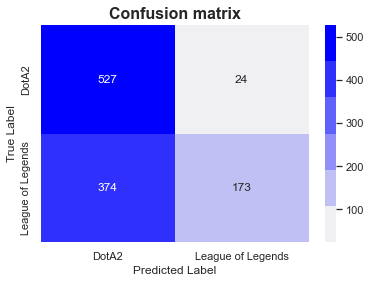

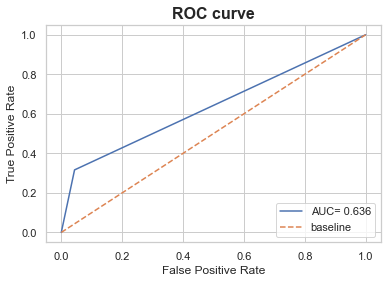

In [26]:
model_eval(gs_vec_knn)

- The scores obtained for KNN are relatively low as compared to Multinomial Naive Bayes and Logistics Regression. The ROC AUC score is low (0.63) where the positive and negative points overlap. This shows that the model is not good at classifying text. 

- Although the model does a relatively good job in predicting the true positive, it has a high number of false negatives.

- Let's see if we can improve the model by hyperparameters tuning.


In [27]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens), check (individual tokens and 2-grams)
# No stop words and english stop words
# n_neighbors: 1, 3, 5, 7, 9
# weights: 'uniform', 'distance'

pipe_params_vec_knn = {
    'vec': [CountVectorizer(), TfidfVectorizer()],
    'vec__stop_words': [None, 'english'],
    'vec__ngram_range': [(1, 1), (1, 2)],
    'vec__max_df': [.9, .95],
    'vec__min_df': [2, 3],
    'vec__max_features': [2_000, 3_000, 4_000, 5_000],
    'knn__n_neighbors':  [5, 10, 15, 20],
    'knn__weights' : ['uniform', 'distance']
}

In [28]:
# Instantiate GridSearchCV with 5-folds cross valiation
gs_vec_knn1 = GridSearchCV(pipe_vec_knn,
                          param_grid=pipe_params_vec_knn,
                          cv=5,
                          n_jobs=-1)

,0,1
0,model,"[('vec', None), ('knn', KNeighborsClassifier())]"
1,optimal Parameters,"{'knn__n_neighbors': 20, 'knn__weights': 'uniform', 'vec': TfidfVectorizer(max_df=0.9, max_features=5000, min_df=2), 'vec__max_df': 0.9, 'vec__max_features': 5000, 'vec__min_df': 2, 'vec__ngram_range': (1, 1), 'vec__stop_words': None}"
2,cross_val_score,0.705859
3,train_score,0.616797
4,test_score,0.612933
5,auc_score,0.611531
6,recall,0.226691
7,precision,0.984127
8,f1_score,0.368499


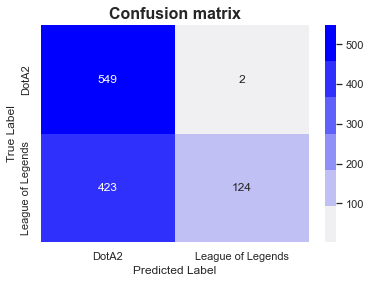

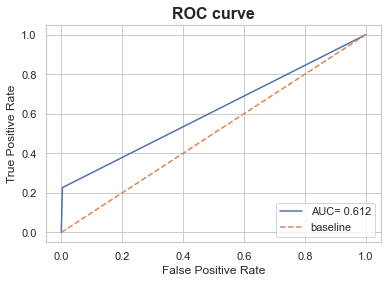

In [29]:
model_eval(gs_vec_knn1)

- The train score did not improve although the precision score has increased to 0.9841. However, the recall decreased to 0.2267. The AUC score has decreased to 0.6115. We conclude that KNN is not suitable to classify texts.


|K-Nearest Neighbors|Optimal Parameter|Train score|Test score|AUC score|Recall score|Precision score|F1 Score
|--|--|--|--|--|--|--|--|
|1|{'vec': CountVectorizer(max_df=0.9, max_features=2000, min_df=3, stop_words='english')}|0.6988|0.6375|0.6364|0.3163|0.8782|0.4651
|2|{'knn__n_neighbors': 20, 'knn__weights': 'uniform', 'vec': TfidfVectorizer(max_df=0.9, max_features=5000, min_df=2)}|0.6168|0.6129|0.6115|0.2267|0.9841|0.3685


**Model Comparison Summary:**

- The model evaluation score is summarized in the table below:

|Model|Optimal Parameter|Train score|Test score|AUC score|Recall score|Precision score|F1 Score
|--|--|--|--|--|--|--|--|
|Multinomial Naive Bayes 1|vec': TfidfVectorizer(max_df=0.9, max_features=5000, min_df=2, ngram_range=(1, 2), stop_words='english')|0.9664|0.8916|0.8917|0.9159|0.8728|0.8939
|<span class="burk">Multinomial Naive Bayes 2|{'nb__alpha': 0.5, 'vec': TfidfVectorizer(max_df=0.9, max_features=4000, min_df=3, stop_words='english')}|0.9734|0.8934|0.8935|0.9104|0.8799|0.8949</span>
|Logistic Regression 1|{'vec': TfidfVectorizer(max_df=0.9, max_features=4000, min_df=2, ngram_range=(1, 2))}|0.9746|0.8834|0.8833|0.8592|0.9021|0.8801
|Logistic Regression 2|{'lr__penalty': 'l2', 'vec': TfidfVectorizer(max_df=0.9, max_features=4000, min_df=2, ngram_range=(1, 2))}|0.9746|0.8834|0.8833|0.8592|0.9021|0.8801
|K-Nearest Neighbors 1|{'vec': CountVectorizer(max_df=0.9, max_features=2000, min_df=3, stop_words='english')}|0.6988|0.6375|0.6364|0.3163|0.8782|0.4651
|K-Nearest Neighbors 2|{'knn__n_neighbors': 20, 'knn__weights': 'uniform', 'vec': TfidfVectorizer(max_df=0.9, max_features=5000, min_df=2)}|0.6168|0.6129|0.6115|0.2267|0.9841|0.3685


- The Multinomial Naive Bayes 2 has the best result given that the model is a simple classification algorithm based on the Bayes Theorem which assumes that every word in a sentence is independent of the other ones.

- KNN has the worst performance. KNN model works by finding its nearest neighbor for the words in the posts. As the vocabulary of the words may not be large enough, the model may have its limitation to perform the search effectively.


In [30]:
# Re-fit the model with best estimator
best_gs = gs_vec_nb1.best_estimator_
best_gs.fit(X_train, y_train)

# Make predictions using the new model
best_test_predict = best_gs.predict(X_test)

# Print result
print('The best model achieves an accuracy score of', round(accuracy_score(y_test,best_test_predict), 4))
print_data(y_test, best_test_predict)

The best model achieves an accuracy score of 0.8934
Accuracy score: 0.893443
ROC AUC score: 0.893504
Precision score: 0.879859
Recall score: 0.91042
F1 score: 0.894879


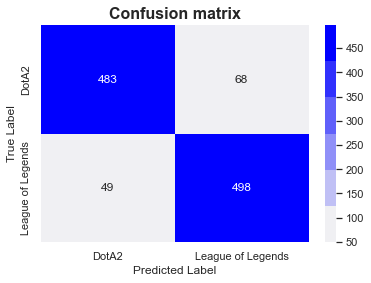

In [31]:
plot_confusion_matrix(y_test, best_test_predict)

### 4.7 Misclassified posts

To analyze posts that are misclassified, we will retrieve the false positive and false negative posts and apply the TfidfVectorizer to retrieve the top 20 words from the misclassified posts.


In [32]:
# Create a new dataframe df_test to store the prediction data
# Create a new column for the prediction data in our df_test
df_test = X_test.to_frame()
df_test['predicted'] = best_test_predict
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098 entries, 2464 to 1447
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text_lem_sen  1098 non-null   object
 1   predicted     1098 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 25.7+ KB


In [33]:
df_test.head()

,text_lem_sen,predicted
2464,share funniest troll comp clashme planning tro...,1
1964,toxic communityi school project unity topic co...,1
2124,tried research demon lore sense demonic compen...,0
1336,macbook air i5hey macbook air i5 gb wonder pro...,0
224,damn nowi started break learn thing ton natura...,0


In [34]:
# Merge the dataset with the main df
df_test = pd.merge(df_test, df, on='text_lem_sen')
df_test.head()

,text_lem_sen,predicted,subreddit,title,selftext,text,text_length,subreddit_int,cleaned_text,text_lem,text_stem,word_counts_lem,word_counts_stem,text_stem_sen
0,share funniest troll comp clashme planning tro...,1,leagueoflegends,Share your funniest troll team comps for clash,Me and my team are planning to play clash with...,Share your funniest troll team comps for clash...,306,1,"['share', 'funniest', 'troll', 'comps', 'clash...","['share', 'funniest', 'troll', 'comp', 'clashm...","['share', 'funniest', 'troll', 'comp', 'clashm...",24,24,share funniest troll comp clashm plan troll co...
1,toxic communityi school project unity topic co...,1,leagueoflegends,How to fix the toxic community.,I am doing a school project on unity and topic...,How to fix the toxic community.I am doing a sc...,271,1,"['toxic', 'communityi', 'school', 'project', '...","['toxic', 'communityi', 'school', 'project', '...","['toxic', 'communityi', 'school', 'project', '...",17,17,toxic communityi school project uniti topic co...
2,tried research demon lore sense demonic compen...,0,leagueoflegends,I tried to research some Demon lore and make s...,I am a big fan of League Demonology (and a Fid...,I tried to research some Demon lore and make s...,427,1,"['tried', 'research', 'demon', 'lore', 'sense'...","['tried', 'research', 'demon', 'lore', 'sense'...","['tri', 'research', 'demon', 'lore', 'sens', '...",24,24,tri research demon lore sens demon compendiumi...
3,macbook air i5hey macbook air i5 gb wonder pro...,0,DotA2,DotA2 on 2020 MacBook Air i5,Hey guys! I have macbook air 2020 i5 8gb and I...,DotA2 on 2020 MacBook Air i5Hey guys! I have m...,194,0,"['macbook', 'air', 'i5hey', 'macbook', 'air', ...","['macbook', 'air', 'i5hey', 'macbook', 'air', ...","['macbook', 'air', 'i5hey', 'macbook', 'air', ...",13,13,macbook air i5hey macbook air i5 gb wonder pro...
4,damn nowi started break learn thing ton natura...,0,DotA2,How is everyone so damn good at this game now,I’ve just started playing more after pretty mu...,How is everyone so damn good at this game nowI...,1447,0,"['damn', 'nowi', 'started', 'break', 'learn', ...","['damn', 'nowi', 'started', 'break', 'learn', ...","['damn', 'nowi', 'start', 'break', 'learn', 't...",78,78,damn nowi start break learn thing ton natur ex...


In [35]:
# Extract the false positive posts (DotA2 post classified as League of Legend)
fp_posts = df_test[df_test['subreddit_int'] == 0]
fp_posts = fp_posts[fp_posts['predicted'] == 1]
fp_posts.head()

,text_lem_sen,predicted,subreddit,title,selftext,text,text_length,subreddit_int,cleaned_text,text_lem,text_stem,word_counts_lem,word_counts_stem,text_stem_sen
17,personal project draw character available acti...,1,DotA2,My first 4 in a personal project to draw one o...,I enjoy all the currently available MOBAs so I...,My first 4 in a personal project to draw one o...,1584,0,"['personal', 'project', 'draw', 'character', '...","['personal', 'project', 'draw', 'character', '...","['person', 'project', 'draw', 'charact', 'avai...",57,57,person project draw charact avail activ mobasi...
26,ping takeni others ping example took spell alt...,1,DotA2,How to ping damage taken.,"I see others ping for example ""I took 650 dama...",How to ping damage taken.I see others ping for...,215,0,"['ping', 'takeni', 'others', 'ping', 'example'...","['ping', 'takeni', 'others', 'ping', 'example'...","['ping', 'takeni', 'other', 'ping', 'exampl', ...",13,13,ping takeni other ping exampl took spell altcl...
30,jingu mastery viperit register jingu charge hi...,1,DotA2,bug with jingu mastery on viper,it only registers jingu charges every 2-3 hits...,bug with jingu mastery on viperit only registe...,84,0,"['jingu', 'mastery', 'viperit', 'registers', '...","['jingu', 'mastery', 'viperit', 'register', 'j...","['jingu', 'masteri', 'viperit', 'regist', 'jin...",8,8,jingu masteri viperit regist jingu charg hit wtf
50,feel exactly boringthe feel play exactly felt ...,1,DotA2,anyone else think this patch feels exactly the...,The game just feels like it plays exactly the ...,anyone else think this patch feels exactly the...,236,0,"['feels', 'exactly', 'boringthe', 'feels', 'pl...","['feel', 'exactly', 'boringthe', 'feel', 'play...","['feel', 'exactli', 'boringth', 'feel', 'play'...",14,14,feel exactli boringth feel play exactli felt p...
54,mind tmrwhats latest,1,DotA2,Mind Games are playing tmr?,What's the latest update?,Mind Games are playing tmr?What's the latest u...,52,0,"['mind', 'tmrwhats', 'latest']","['mind', 'tmrwhats', 'latest']","['mind', 'tmrwhat', 'latest']",3,3,mind tmrwhat latest


In [36]:
# Apply TfidfVectorizer with the optimal parameters
tvec = TfidfVectorizer(max_df=0.9, max_features=4000, min_df=3, stop_words='english')

# Fit the posts
tvec.fit(fp_posts['text_lem_sen'])

# Transforming using the fitted cvec and converting the result to a DataFrame
fp_words = pd.DataFrame(tvec.transform(fp_posts['text_lem_sen']).todense(),
                       columns=tvec.get_feature_names_out())

# Finding the top 20 words that frequently appeared in dota
fp_top20 = fp_words.sum(axis = 0).sort_values(ascending = False).head(20)
fp_top20

ping        3.377947
mind        3.149814
seen        3.069144
view        3.025679
poll        3.025679
ampx200b    3.011065
random      2.739522
champion    2.608638
que         2.399729
minute      2.373175
exactly     2.360720
long        2.291874
max         2.168867
session     2.127010
party       2.013061
le          1.896784
hero        1.873512
hit         1.862323
youre       1.783833
tier        1.728779
dtype: float64

In [37]:
# Extract the false negative posts (League of Legend post classified as DotA2)
fn_posts = df_test[df_test['subreddit_int']== 1]
fn_posts = fn_posts[fn_posts['predicted'] == 0]
fn_posts.head()

,text_lem_sen,predicted,subreddit,title,selftext,text,text_length,subreddit_int,cleaned_text,text_lem,text_stem,word_counts_lem,word_counts_stem,text_stem_sen
2,tried research demon lore sense demonic compen...,0,leagueoflegends,I tried to research some Demon lore and make s...,I am a big fan of League Demonology (and a Fid...,I tried to research some Demon lore and make s...,427,1,"['tried', 'research', 'demon', 'lore', 'sense'...","['tried', 'research', 'demon', 'lore', 'sense'...","['tri', 'research', 'demon', 'lore', 'sens', '...",24,24,tri research demon lore sens demon compendiumi...
8,another updade another v1294403307i tried clos...,0,leagueoflegends,Help another updade another problem (client) V...,I have tried closing the game through the pane...,Help another updade another problem (client) V...,247,1,"['another', 'updade', 'another', 'v1294403307i...","['another', 'updade', 'another', 'v1294403307i...","['anoth', 'updad', 'anoth', 'v1294403307i', 't...",19,19,anoth updad anoth v1294403307i tri close panel...
32,m problemwhen idle ingame m engage spike ish s...,0,leagueoflegends,ms problem,When im idle ingame my ms is 44 but when I try...,ms problemWhen im idle ingame my ms is 44 but ...,218,1,"['ms', 'problemwhen', 'idle', 'ingame', 'ms', ...","['m', 'problemwhen', 'idle', 'ingame', 'm', 'e...","['ms', 'problemwhen', 'idl', 'ingam', 'ms', 'e...",13,13,ms problemwhen idl ingam ms engag spike ish se...
33,ward slot inventoryi modify slot stack type wa...,0,leagueoflegends,Wards' slot in inventory,I think they should modify the ward slot so th...,Wards' slot in inventoryI think they should mo...,593,1,"['wards', 'slot', 'inventoryi', 'modify', 'slo...","['ward', 'slot', 'inventoryi', 'modify', 'slot...","['ward', 'slot', 'inventoryi', 'modifi', 'slot...",43,43,ward slot inventoryi modifi slot stack type wa...
51,spellthief edge mechanicscan explain work incr...,0,leagueoflegends,Spellthief’s edge mechanics,Can someone please explain how this item actua...,Spellthief’s edge mechanicsCan someone please ...,270,1,"['spellthief', 'edge', 'mechanicscan', 'explai...","['spellthief', 'edge', 'mechanicscan', 'explai...","['spellthief', 'edg', 'mechanicscan', 'explain...",11,11,spellthief edg mechanicscan explain work incre...


In [38]:
# Apply TfidfVectorizer with the optimal parameters
tvec = TfidfVectorizer(max_df=0.9, max_features=4000, min_df=3, stop_words='english')

# Fit the posts
tvec.fit(fn_posts['text_lem_sen'])

# Transforming using our fitted cvec and converting the result to a DataFrame
fn_words = pd.DataFrame(tvec.transform(fn_posts['text_lem_sen']).todense(),
                       columns=tvec.get_feature_names_out())

# Finding the top 20 words that frequently appeared in league
fn_top20 = fn_words.sum(axis = 0).sort_values(ascending = False).head(20)
fn_top20

explain        3.000000
join           2.942659
making         2.513986
started        2.377964
tried          2.310721
discord        2.267151
normal         2.178884
custom         2.177803
teammate       2.156631
tournament     2.087367
competitive    1.905485
possible       1.869719
friend         1.863737
link           1.837720
add            1.612592
decide         1.477603
legend         1.353137
free           1.266654
low            1.264420
google         1.199463
dtype: float64

- The below table summarizes the top 20 words for the misclassified posts. 

|DotA2     |League of Legends |
|----------|------------------|
|ping      |explain           |
|mind      |join              |
|seen      |making            |
|view      |started           |
|poll      |tried             |
|ampx200b  |discord           |
|random    |normal            |
|champion  |custom            |
|que       |teamate           |
|minute    |tournament        |
|exactly   |competitive       |
|long      |possible          |
|max       |friend            |
|session   |link              |
|party     |add               |
|le        |decide            |
|hero      |legend            |
|hit       |free              |
|youre     |low               |
|tier      |google            |

- From the top 20 words extracted, the reasons why the posts are classified wrongly are:
    - Overlapping of the keywords for both posts (e.g. ping, champion).
    - Generic words (e.g. seen, view, tried, add) may be used in both posts.

- To reduce the number of misclassification (i.e. improving the accuracy), further analysis of the key and generic words is required. Overlapping of the keywords for both posts should be reduced. We can also consider adding generic words to the stopwords list.

### 4.8 Feature Importance

To check which words have a stronger predicting power in determining whether the topic is DotA2 or League of Legends, we will look at the feature importance for the models.

In [39]:
# Create a function to get the feature importance for multinomial naive bayes model
def get_feature_importances_NB(estimator, transformer, ascending=True):

    delta_log_prob = estimator.feature_log_prob_[1, :] - estimator.feature_log_prob_[0, :]    
    words = transformer.get_feature_names_out()
    df = pd.DataFrame({'feature': words, 'log_prob_difference': delta_log_prob})
    df.sort_values(by=['log_prob_difference'], inplace=True, ascending=ascending)

    return df

In [40]:
# Extract multinomial naive bayes feature importance for Dota 
get_feature_importances_NB(gs_vec_nb1.best_estimator_.named_steps.nb, 
                           gs_vec_nb1.best_estimator_.named_steps.vec)[:5]

,feature,log_prob_difference
3758,valve,-3.715620
1576,hero,-3.702691
3671,underlord,-3.454362
3324,stockholm,-3.425489
1161,esl,-3.282272


In [41]:
# Extract multinomial naive bayes feature importance for league
get_feature_importances_NB(gs_vec_nb1.best_estimator_.named_steps.nb, 
                           gs_vec_nb1.best_estimator_.named_steps.vec, ascending=False)[:5]

,feature,log_prob_difference
2212,msi,3.586555
2949,riot,3.562656
548,challenge,3.541638
554,champion,3.291143
3548,token,3.216725


In [42]:
# Create a function to get the feature importance for logistic regression model
def get_feature_importances_LR(estimator, transformer, ascending=True):

    df = pd.DataFrame(transformer.get_feature_names_out(), columns=['feature'])
    df['lr_coef'] = estimator.coef_.T
    df['lr_coef_exp'] = np.exp(df['lr_coef'])
    df.sort_values(by=['lr_coef'], inplace=True, ascending=ascending)

    return df

In [43]:
# Extract logistic regression feature importance for dota
get_feature_importances_LR(gs_vec_lr1.best_estimator_.named_steps.lr, 
                           gs_vec_lr1.best_estimator_.named_steps.vec)[:5]

,feature,lr_coef,lr_coef_exp
1516,hero,-4.903649,0.007419
3756,valve,-3.683061,0.025146
2025,major,-2.898566,0.055102
3521,ti,-1.920352,0.146555
3288,steam,-1.853549,0.156680


In [44]:
# Extract logistic regression feature importance for league
get_feature_importances_LR(gs_vec_lr1.best_estimator_.named_steps.lr, 
                           gs_vec_lr1.best_estimator_.named_steps.vec, ascending=False)[:5]

,feature,lr_coef,lr_coef_exp
2892,riot,4.842819,126.826398
497,champion,3.951085,51.991765
2209,msi,3.928786,50.845232
488,challenge,3.852484,47.109926
495,champ,3.407010,30.174887


- The below table summarizes the top 5 features based on their coefficients. 

|Model                  |Post             |Top 5 Features                        |
|-----------------------|-----------------|--------------------------------------|
|Multinomial Navie Bayes|DotA2            |valve, hero, underlord, stockholm, esl|
|Multinomial Navie Bayes|League of Legends|msi, riot, challenge, champion, token |
|Logistic Regression    |DotA2            |hero, valve, major, ti, steam         |
|Logistic Regression    |League of Legends|riot, champion, msi, challenge, champ |


- Based on the Multinomial Naive Bayes model:
    - Words like valve, hero, underload, Stockholm, and esl are likely to belong to the DotA2 topic.
    - Words like msi, riot, challenge, champion, and token are likely to belong to the League of Legends topic.


- Based on the Logistic Regression model:
    - Words like hero, valve, major, ti, and steam are likely to belong to the DotA2 topic.
    - Words like riot, champion, msi, challenge, and champ are likely to belong to the League of Legends topic.


- The top 5 features for both models have some similarities. So the words obtained are significant features that differentiate the two topics.


## 5. Conclusions

- The best model obtained is the Multinomial Naive Bayes classifier with Tfidf Vectorizer. The model has proven to be able to distinguish the words for the two topics with an accuracy of 89.3%. Hyper-tuning the alpha parameter improved the score by 0.14%.


- The best model scores are summarized below:
    - Accuracy: 89.3%
    - Recall: 91.0%
    - Precision: 88.0%
    - AUC Score: 89.3%
    - F1 Score: 89.5%


- The reasons for misclassified posts are the overlapping of keywords and generic words used for both posts and generic. To reduce the number of misclassification (i.e. improving the accuracy), further analysis of the key and generic words is required. Overlapping of the keywords for both posts should be reduced. We can also consider adding generic words to the stopwords list.


- From our analysis, we have identified the top 5 keywords like `valve`, `hero`, `underload`, `stockholm`, and `esl` for DotA2. League of Legends has keywords `msi`, `riot`, `challenge`, `champion`, and `token`. Post with these keywords means it has a higher possibility that it belongs to that topic. The Marketing team can use these keywords for insights when they brainstorm for their campaigns.


## 6. Limitations

- We have yet to analyze the set of words for both posts which resulted in some posts being misclassified. In addition, the current set of words obtained may not be represented as the dataset is considered relatively small. To further improve, we should analyze on:
    - the overlapping/generic keywords and consider removing them.
    - consider getting more data from Reddit or other social media platforms.   


## 7. Recommendations

- We have successfully developed a text classifier to categorize the top 2 popular games and identify the top 5 features.

- Although we have obtained a model with an accuracy of 85%, we can try to further improve the model accuracy to above 90%. To achieve this, we can consider to:
    - Increase the dataset size by scrapping more posts.
    - Expand the scope of scrapping using other websites / social platforms (e.g. Twitter) to increase the word vocabulary for better accuracy.
    - Experiment with other classifiers and boosting techniques (e.g. Random Forest, Gradient Boosting).


- To reduce the misclassification rate for our models, analysis of the overlapping and generic words is recommended. The words identified should be removed during the text preprocessing stage.

- With the top keywords, the Marketing team can think of using them to create meaningful topics to engage the users in the forum.


## 8. Future Actions

Moving forward, we will explore doing sentiment analysis for these 2 top popular games and make recommendations to the marketing / business development team to consider for their sales & marketing plans.